# Αναγνώριση Προτύπων / Μηχανική Μάθηση - Εργασία 3
---
Δίνουμε στο πρόγραμμα πρόσβαση στο google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Εισάγουμε τις κατάλληλλες βιβλιοθήκες


In [1]:
# Library for zip files
import zipfile

# Numpy library
import numpy as np

# Pytorch Library
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Torchmetrics
%pip install torchmetrics
from torchmetrics.classification import F1Score, Accuracy, ConfusionMatrix

# Sci-Kit Learn library
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Time
import time

# Matplotlib library 
import matplotlib.pyplot as plt

# Pandas Library
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 17.0 MB/s eta 0:00:00


Αποσυμπιέζουμε το data.zip. Τα δεδομένα που θα χρησιμοποιήσετε βρίσκονται εδώ και είναι χωρισμένα στα σύνολα
training (3200 δείγματα), validation (800 δείγματα) και test (1376 δείγματα) sets, τα οποία
θα χρησιμοποιηθούν για εκπαίδευση, εύρεση υπερπαραμέτρων και αξιολόγηση της
ικανότητας γενίκευσης αντίστοιχα.

In [4]:
# Specify the path to the zip file
zip_path = '/content/drive/MyDrive/data.zip'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  
    # Extract all the contents of the zip file
    zip_ref.extractall('/content')

## Ερώτημα 1: Feedforward Neural Network
---

### Βήμα 1: Φόρτωση δεδομένων (mfccs)

Τα MFCCs είναι συντελεστές του φάσματος ισχύος μετασχηματισμένοι με βάση την κλίμακα
mel, μία κλίμακα που είναι κοντά στον τρόπο που αντιλαμβάνεται ο άνθρωπος τα ηχητικά
σήματα μέσω της ακοής. Στην δική μας περίπτωση χρησιμοποιούμε 13 συντελεστές οι οποίοι
υπολογίζονται για κάθε 50 msec και επομένως για κάθε μουσικό κομμάτι του dataset
προκύπτει μία ακολουθία από 20 feature vectors διάστασης 13. Για να αναπαραστήσουμε
αυτή την πληροφορία μέσω ενός στατικού διανύσματος, το οποίο είναι ευκολότερο στην
χρήση, υπολογίζουμε για κάθε έναν από τους 13 συντελεστές την μέση τιμή και την τυπική
του απόκλιση από την ακολουθία των 20 χρονικών στιγμών. Καταλήγουμε λοιπόν με ένα
διάνυσμα 26 χαρακτηριστικών για κάθε μουσικό κομμάτι του dataset.

Ξεκινάμε φορτώνοντας τα mfcc δεδομένα για train, validation και test μέσω των αντίστοιχων
numpy αρχείων X.npy και labels.npy. 

In [118]:
# Specify the paths to the .npy files
npy_test_file_path = '/content/music_genre_data_di/test/mfccs/'
npy_train_file_path = '/content/music_genre_data_di/train/mfccs/'
npy_val_file_path = '/content/music_genre_data_di/val/mfccs/'

# Specify the .npy files
data_file = 'X.npy'
target_file = 'labels.npy'

# Load the .npy test files
X_test = np.load(npy_test_file_path + data_file)
y_test = np.load(npy_test_file_path + target_file)

# Load the .npy test files
X_train = np.load(npy_train_file_path + data_file)
y_train = np.load(npy_train_file_path + target_file)

# Load the .npy test files
X_val = np.load(npy_val_file_path + data_file)
y_val = np.load(npy_val_file_path + target_file)

# Evaluating the shapes
print(X_test.shape)
print(y_test.shape)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)


(1376, 26)
(1376,)
(3200, 26)
(3200,)
(800, 26)
(800,)


Στην συνέχεια μετασχηματίζουμε τα labels από strings
(classical, blues etc) σε ακέραιους αριθμούς από 0 μέχρι 3, κρατώντας το αντίστοιχο mapping
από τα ονόματα των κλάσεων στους ακεραίους. 


In [6]:
'''
  Function that converts a numpy array with words to integers
'''
def numpy_str_to_numpy_int(y_str):
  
  # Get unique words in the array
  unique_words = np.unique(y_str)

  # Create a dictionary mapping of unique words to numbers
  word_to_number = {word: number for number, word in enumerate(unique_words)}

  # Convert words to numbers
  y_int = np.array([word_to_number[word] for word in y_str])

  return y_int

Ας το κάνουμε.

In [119]:
# Converting string numpy matrices to int numpy matrices
y_train_int = numpy_str_to_numpy_int(y_train)
y_test_int = numpy_str_to_numpy_int(y_test)
y_val_int = numpy_str_to_numpy_int(y_val)

Πρέπει να φτιάξουμε 3 ξεχωριστά datasets για τα train, test και validation data. Ξεκινάμε μετατρέποντας τα Numpy δεδομένα σε Torch Tensor.

In [120]:
# Converting the numpy data to torch data
training_tensor_data = torch.from_numpy(X_train)
test_tensor_data = torch.from_numpy(X_test)
validation_tensor_data = torch.from_numpy(X_val)

# Converting the numpy labels to torch labels
training_tensor_labels = torch.from_numpy(y_train_int)
test_tensor_labels = torch.from_numpy(y_test_int)
validation_tensor_labels = torch.from_numpy(y_val_int)

Φτιάχνουμε τα datasets.

In [121]:
# Initializing the datasets with both data and labels
training_data = TensorDataset(training_tensor_data, training_tensor_labels)
test_data = TensorDataset(test_tensor_data, test_tensor_labels)
validation_data = TensorDataset(validation_tensor_data, validation_tensor_labels)

Τέλος φορτώνουμε τα δεδομένα μας σε 3
Pytorch dataloaders (ένα για κάθε σύνολο δεδομένων) με batch size 16, ώστε να μπορούν
να χρησιμοποιηθούν στα μοντέλα μας. Δώστε επίσης το όρισμα shuffle=True στους train και
validation dataloaders.

In [122]:
# Initializing the dataloaders with batch size 16
batch_size = 16
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

### Βήμα 2: Ορισμός Νευρωνικού Δικτύου
---
Ορίστε μία κλάση πλήρως συνδεδεμένου Νευρωνικού Δικτύου (fully connected neural
nework) το οποίο να αποτελείται από τα 4 επίπεδα με αριθμούς νευρώνων 26, 128, 32 και 4
αντίστοιχα, όπου 26 είναι η διάσταση της εισόδου και 4 ο αριθμός των κλάσεων που θα
προβλεφθούν.

In [123]:
class NeuralNetwork(nn.Module): ##NeuralNetwork iS A subclass of nn.module
    def __init__(self):
        super(NeuralNetwork, self).__init__() ## call the constructor of super
        self.flatten = nn.Flatten()
        ## sound 26 --> 128 --> 32 --> 4 
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 128),  ## torch.nn.Linear(in_features, out_features) 26 --> 128
            nn.ReLU(),
            nn.Linear(128, 32),   ## 128 --> 32
            nn.ReLU(),
            nn.Linear(32, 4),     ## 32 --> 4
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        x = self.flatten(x)
        x = x.to(self.linear_relu_stack[0].weight.dtype)
        logits = self.linear_relu_stack(x)
        return logits

Αρχικοποιούμε το CPU.

In [124]:
device="cpu"

Στη συνέχεια δημιουργείται ένα στιγμιότυπο (model) της κλάσης NeuralNetwork, το μετακινούμε στη συσκευή (CUDA ή CPU) και εκτυπώνουμε τη δομή του.

In [125]:
model_cpu = NeuralNetwork().to(device)

# print the model structure
print(model_cpu)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


### Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης
---
Ορίστε μία συνάρτηση που θα είναι αρμόδια για την εκπαίδευση του δικτύου. Συγκεκριμένα,
δεδομένου ενός αριθμού εποχών, ενός optimizer, ενός dataloader, μιας συνάρτησης
κόστους και ενός νευρωνικού θα περνάει κάθε batch από το νευρωνικό, θα υπολογίζει και
θα τυπώνει το loss και θα ενημερώνει τα βάρη, ενώ θα τερματίζει επιστρέφοντας το
νευρωνικό δίκτυο, όταν ο αριθμός των εποχών επιτευχθεί.

In [126]:
'''
  Assisstant function that trains only one epoch (needed for evaluation)
'''
def train_loop(dataloader, model, loss_fn, optimizer):
  
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # per 100 batches report the value of the loss function on the training set
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


'''
  Training function that trains a dataset in a given number of epochs with neural_network, loss function and optimizer given 
'''
def train_all_epochs(num_epochs, dataloader, model, loss_fn, optimizer):

  for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, model, loss_fn, optimizer)
    print("\n")
  print("Done!")


### Βήμα 4: Ορισμός διαδικασίας αξιολόγησης
---
Ορίστε αντίστοιχα μία συνάρτηση αξιολόγησης, η οποία θα περνάει όλα τα batches ενός
dataloader από το μοντέλο παίρνοντας τις προβλέψεις του και χωρίς να ενημερώνει τα βάρη.
Μέσω των προβλέψεων θα υπολογίζει και θα επιστρέφει (i) το loss, (ii) τo f1 macro averaged,
(iii) το accuracy, και (iv) confusion matrix.

In [127]:
'''
  The test loop does not need the optimizer.
  We just pass the data through the trained model and measure the error in predictions.
  Returns a tuple with all the metrics asked for.
'''
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    f1_metric = F1Score(task="multiclass", num_classes=4, average="macro").to(device)
    accuracy_metric = Accuracy(task="multiclass", num_classes=4).to(device)
    confusion_metric = ConfusionMatrix(task="multiclass", num_classes=4).to(device)

    with torch.no_grad():
        for X, y in dataloader:
            # if using gpu don't forget to move the data there
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # Update the metric objects with predictions and labels
            f1_metric.update(pred, y)
            accuracy_metric.update(pred, y)
            confusion_metric.update(pred, y)

    # Calculate metrics
    f1 = f1_metric.compute()
    accuracy = accuracy_metric.compute()
    confusion = confusion_metric.compute().cpu().numpy()

    test_loss /= size

    return (test_loss, f1, accuracy, confusion)

### Βήμα 5: Εκπαίδευση δικτύου
---
Εκπαιδεύστε το νευρωνικό δίκτυο στο training set χρησιμοποιώντας τα εξής:
- optimizer: stochastic gradient descent
- learning rate: 0.002
- loss function: cross-entropy loss
- αριθμός εποχών: 30


In [128]:
# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate = 0.002

# define the optimizer object
optimizer = torch.optim.SGD(model_cpu.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

# Start the timer
start_train_time_cpu = time.time()

train_all_epochs(num_epochs, train_dataloader, model_cpu, loss_fn, optimizer)

# Calculate the elapsed time
end_train_time_cpu = time.time()
elapsed_train_time_cpu = end_train_time_cpu - start_train_time_cpu

Epoch 1
-------------------------------
loss: 1.428909  [    0/ 3200]
loss: 1.381961  [ 1600/ 3200]


Epoch 2
-------------------------------
loss: 1.365867  [    0/ 3200]
loss: 1.377983  [ 1600/ 3200]


Epoch 3
-------------------------------
loss: 1.406536  [    0/ 3200]
loss: 1.392999  [ 1600/ 3200]


Epoch 4
-------------------------------
loss: 1.375685  [    0/ 3200]
loss: 1.381662  [ 1600/ 3200]


Epoch 5
-------------------------------
loss: 1.363906  [    0/ 3200]
loss: 1.341709  [ 1600/ 3200]


Epoch 6
-------------------------------
loss: 1.318802  [    0/ 3200]
loss: 1.372121  [ 1600/ 3200]


Epoch 7
-------------------------------
loss: 1.355758  [    0/ 3200]
loss: 1.370813  [ 1600/ 3200]


Epoch 8
-------------------------------
loss: 1.347590  [    0/ 3200]
loss: 1.360006  [ 1600/ 3200]


Epoch 9
-------------------------------
loss: 1.368779  [    0/ 3200]
loss: 1.359395  [ 1600/ 3200]


Epoch 10
-------------------------------
loss: 1.347055  [    0/ 3200]
loss: 1.354

Στην συνέχεια χρησιμοποιήστε την συνάρτηση αξιολόγησης του προηγούμενου ερωτήματος
για να υπολογίσετε τις επιδόσεις του εκπαιδευμένου μοντέλου στο test set.

In [129]:
# Start the timer
start_test_time_cpu = time.time()

results = test_loop(test_dataloader, model_cpu, loss_fn)
print(f"Test Error: \n Avg loss: {results[0]:>8f},  F1 macro average: {(100*results[1]):>0.1f}%,  Accuracy: {(100*results[2]):>0.1f}%,  \n")
print("Confusion Matrix:")
print(results[3])


# Calculate the elapsed time
end_test_time_cpu = time.time()
elapsed_test_time_cpu = end_test_time_cpu - start_test_time_cpu

Test Error: 
 Avg loss: 0.065258,  F1 macro average: 58.0%,  Accuracy: 58.7%,  

Confusion Matrix:
[[ 96  23 156  49]
 [ 40 236  17   4]
 [ 50  11 292   3]
 [ 82  33 100 184]]


Παρατηρούμε ότι τα αποτελέσματα είναι αρκετά παρόμοια μεταξύ τους με την απώλεια δεδομένων να έιναι γύρω στο 0.064, το f1 score γύρω στο 60.1% και την ακρίβεια να είναι γύρω στο 60.4%. Παρατηρούμε επίσης ότι με συχνότερη εκπαίδευση (όσες περισσότερες φορές εκτελείται το πρόγραμμα με το train_loop) τόσο πιο καλές επιδόσεις υπάρχουν.

### Βήμα 6: Εκπαίδευση δικτύου με GPU
---
Επαναλάβετε το βήμα 5, αλλά αυτή την φορά να έχετε αρχικά μεταφέρει τα δεδομένα και το
αρχικοποιημένο νευρωνικό σας δίκτυο στην GPU του colab. Βεβαιωθείτε ότι η εκπαίδευση
τρέχει στην GPU και τυπώστε τις διαφορές στους χρόνους εκτέλεσης σε GPU και CPU.
Βεβαιωθείτε ότι το colab session σας περιλαμβάνει χρήση GPU - η οποία είναι δωρεάν.

In [130]:
# if we want to utilize the GPU (if available), we need to assign the model to the correct device

if torch.cuda.is_available():
  device="cuda"
else:
    device="cpu"

print ("device=",device)

device= cuda


Πρέπει να ξαναφτιάξουμε απο την αρχή νέο στιγμυότυπο του νευρωνικού δικτύου με συσκευή την GPU.

In [131]:
model_gpu = NeuralNetwork().to(device)

# print the model structure
print(model_gpu)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


Εκπαιδεύουμε τα δεδομένα με το νέο μοντέλο.

In [132]:
# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate = 0.002

# define the optimizer object
optimizer = torch.optim.SGD(model_gpu.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

# Start the timer
start_train_time_gpu = time.time()

train_all_epochs(num_epochs, train_dataloader, model_gpu, loss_fn, optimizer)

# Calculate the elapsed time
end_train_time_gpu = time.time()
elapsed_train_time_gpu = end_train_time_gpu - start_train_time_gpu

Epoch 1
-------------------------------
loss: 1.552343  [    0/ 3200]
loss: 1.372687  [ 1600/ 3200]


Epoch 2
-------------------------------
loss: 1.372433  [    0/ 3200]
loss: 1.369089  [ 1600/ 3200]


Epoch 3
-------------------------------
loss: 1.402597  [    0/ 3200]
loss: 1.356553  [ 1600/ 3200]


Epoch 4
-------------------------------
loss: 1.382360  [    0/ 3200]
loss: 1.396070  [ 1600/ 3200]


Epoch 5
-------------------------------
loss: 1.399922  [    0/ 3200]
loss: 1.358548  [ 1600/ 3200]


Epoch 6
-------------------------------
loss: 1.387390  [    0/ 3200]
loss: 1.370736  [ 1600/ 3200]


Epoch 7
-------------------------------
loss: 1.347966  [    0/ 3200]
loss: 1.313759  [ 1600/ 3200]


Epoch 8
-------------------------------
loss: 1.333839  [    0/ 3200]
loss: 1.329455  [ 1600/ 3200]


Epoch 9
-------------------------------
loss: 1.379046  [    0/ 3200]
loss: 1.360408  [ 1600/ 3200]


Epoch 10
-------------------------------
loss: 1.302205  [    0/ 3200]
loss: 1.320

Αξιολογούμε με το νέο μοντέλο.

In [133]:
# Start the timer
start_test_time_gpu = time.time()

results = test_loop(test_dataloader, model_gpu, loss_fn)
print(f"Test Error: \n Avg loss: {results[0]:>8f},  F1 macro average: {(100*results[1]):>0.1f}%,  Accuracy: {(100*results[2]):>0.1f}%,  \n")
print("Confusion Matrix:")
print(results[3])

# Calculate the elapsed time
end_test_time_gpu = time.time()
elapsed_test_time_gpu = end_test_time_gpu - start_test_time_gpu

Test Error: 
 Avg loss: 0.062339,  F1 macro average: 59.1%,  Accuracy: 61.3%,  

Confusion Matrix:
[[ 72  42  99 111]
 [ 28 251  10   8]
 [ 47  21 268  20]
 [ 50  45  52 252]]


Εδώ είναι οι διαφορές χρόνου μεταξύ CPU και GPU.

In [135]:
print(f"GPU and CPU have a time difference in training of: {(elapsed_train_time_cpu-elapsed_train_time_gpu):>8f} seconds" )
print(f"GPU and CPU have a time difference in tests of: {(elapsed_test_time_cpu-elapsed_test_time_gpu):>8f} seconds" )

GPU and CPU have a time difference in training of: -1.601119 seconds
GPU and CPU have a time difference in tests of: -0.081113 seconds


Παρατηρούμε ότι η GPU κάνει αρκετά γρηγορότερα από την CPU αλλά αυτό συμβαίνει με κόστος τις επιδόσεις της που είναι υποδεέστερες. Για αυτό στο Βήμα 7 θα χρησιμοποιήσουμε το μοντέλο της CPU.

In [134]:
device="cpu"

### Βήμα 7: Επιλογή μοντέλου
---
Κατά την διάρκεια εκπαίδευσης (30 εποχές) προκύπτουν διαφορετικά στιγμιότυπα του
νευρωνικού μας, δηλαδή μοντέλα που έχουν διαφορετικά βάρη. Κατά την διαδικασία
βελτιστοποίησης, δεν γνωρίζουμε ποιο στιγμιότυπο του μοντέλου μας έχει την καλύτερη
δυνατότητα γενίκευσης. Για τον λόγο αυτό θα χρησιμοποιήσουμε το validation set στο τέλος
κάθε εποχής ώστε να αξιολογούμε τα στιγμιότυπα του μοντέλου. 

In [136]:
max_f1 = 0
best_model_cpu = None
max_epoch = 0

# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate = 0.002

# define the optimizer object
optimizer = torch.optim.SGD(model_cpu.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Training the data
    train_loop(train_dataloader, model_cpu, loss_fn, optimizer)

    # Validating the data
    results = test_loop(validation_dataloader, model_cpu, loss_fn)

    # Evaluating if the current model has the best f1 score
    current_f1 = results[1]
    if current_f1 >= max_f1:
      max_epoch = t+1
      best_model_cpu = model_cpu
      max_f1 = current_f1

print("Done!")


Epoch 1
-------------------------------
loss: 0.897516  [    0/ 3200]
loss: 1.201903  [ 1600/ 3200]
Epoch 2
-------------------------------
loss: 1.153181  [    0/ 3200]
loss: 1.112458  [ 1600/ 3200]
Epoch 3
-------------------------------
loss: 1.222454  [    0/ 3200]
loss: 0.983327  [ 1600/ 3200]
Epoch 4
-------------------------------
loss: 1.082978  [    0/ 3200]
loss: 1.245098  [ 1600/ 3200]
Epoch 5
-------------------------------
loss: 0.838440  [    0/ 3200]
loss: 0.884475  [ 1600/ 3200]
Epoch 6
-------------------------------
loss: 1.062561  [    0/ 3200]
loss: 1.122417  [ 1600/ 3200]
Epoch 7
-------------------------------
loss: 0.915510  [    0/ 3200]
loss: 0.864010  [ 1600/ 3200]
Epoch 8
-------------------------------
loss: 0.928485  [    0/ 3200]
loss: 1.107704  [ 1600/ 3200]
Epoch 9
-------------------------------
loss: 0.861260  [    0/ 3200]
loss: 0.895107  [ 1600/ 3200]
Epoch 10
-------------------------------
loss: 0.860151  [    0/ 3200]
loss: 1.021538  [ 1600/ 3200]

Αποθηκεύστε το μοντέλο
που έχει την καλύτερη επίδοση στην μετρική f1 για το validation set και χρησιμοποιήστε το
για να μετρήσετε την απόδοση στο test set. Σχολιάστε τα αποτελέσματα.

In [137]:
# Evaluating the test data with the best model

print(f"Best Epoch: ", max_epoch)
results = test_loop(test_dataloader, best_model_cpu, loss_fn)
print(f"Test Error: \n Avg loss: {results[0]:>8f},  F1 macro average: {(100*results[1]):>0.1f}%,  Accuracy: {(100*results[2]):>0.1f}%,  \n")
print("Confusion Matrix:")
print(results[3])
print("\n")


Best Epoch:  29
Test Error: 
 Avg loss: 0.058276,  F1 macro average: 61.0%,  Accuracy: 62.4%,  

Confusion Matrix:
[[ 93  28  58 145]
 [ 28 238   7  24]
 [ 78  14 224  40]
 [ 27  34  35 303]]




Πήραμε καλύτερα αποτελέσματα από ότι πριν επειδή πήραμε το μοντέλο με τις καλύτερες επιδόσεις στην εκπαίδευση.

## Ερώτημα 2: Convolutional Neural Network
---
Στο ερώτημα αυτό θα χρησιμοποιήσουμε τα mel-spectrograms σαν εισόδους σε Συνελικτικά
Νευρωνικά Δίκτυα με σκοπό την ταξινόμηση μουσικού είδους.

### Βήμα 1: Φόρτωση δεδομένων (spectrograms)
---
Ακολουθήστε την διαδικασία του ερωτήματος 1.1, αλλά αυτή τη φορά για τα melgrams.



In [5]:
# Specify the paths to the .npy files
npy_test_file_path = '/content/music_genre_data_di/test/melgrams/'
npy_train_file_path = '/content/music_genre_data_di/train/melgrams/'
npy_val_file_path = '/content/music_genre_data_di/val/melgrams/'

# Specify the .npy files
data_file = 'X.npy'
target_file = 'labels.npy'

# Load the .npy test files
X_test = np.load(npy_test_file_path + data_file)
y_test = np.load(npy_test_file_path + target_file)

# Load the .npy test files
X_train = np.load(npy_train_file_path + data_file)
y_train = np.load(npy_train_file_path + target_file)

# Load the .npy test files
X_val = np.load(npy_val_file_path + data_file)
y_val = np.load(npy_val_file_path + target_file)

# Evaluating the shapes
print(X_test.shape)
print(y_test.shape)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(1376, 21, 128)
(1376,)
(3200, 21, 128)
(3200,)
(800, 21, 128)
(800,)


Επαναλαμβάνουμε όλες τις ενέργειες από το βήμα 1.1 για τα melgrams. Τα φορτώνουμε σε dataloaders και όλα τα ενδιάμεσα βήματα. 

In [7]:
# Converting string numpy matrices to int numpy matrices
y_train_int = numpy_str_to_numpy_int(y_train)
y_test_int = numpy_str_to_numpy_int(y_test)
y_val_int = numpy_str_to_numpy_int(y_val)

In [8]:
# Converting the numpy data to torch data
training_tensor_data = torch.from_numpy(X_train)
test_tensor_data = torch.from_numpy(X_test)
validation_tensor_data = torch.from_numpy(X_val)

# Converting the numpy labels to torch labels
training_tensor_labels = torch.from_numpy(y_train_int)
test_tensor_labels = torch.from_numpy(y_test_int)
validation_tensor_labels = torch.from_numpy(y_val_int)

In [9]:
# Initializing the datasets with both data and labels
training_data = TensorDataset(training_tensor_data, training_tensor_labels)
test_data = TensorDataset(test_tensor_data, test_tensor_labels)
validation_data = TensorDataset(validation_tensor_data, validation_tensor_labels)

In [10]:
# Initializing the dataloaders with batch size 16
batch_size = 16
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

To φασματογράφημα (spectrogram), που είναι ο δεύτερος τρόπος αναπαράστασης που θα
χρησιμοποιήσουμε, είναι μία δισδιάστατη αναπαράσταση που δείχνει την χρονική εξέλιξη
του φάσματος συχνοτήτων. Εάν στο spectrogram εφαρμόσουμε την κλίμακα mel, παίρνουμε
το mel-spectrogram ή melgram με το οποίο και θα δουλέψουμε στην παρούσα εργασία.
Υπολογίζοντας και αντιστρέφοντας τους άξονες χρόνου και συχνότητας, προκύπτει για κάθε
στοιχείο του συνόλου δεδομένων ένας πίνακας 21 (χρόνος) x 128 (συχνότητα).

Διαλέγουμε ένα τυχαίο melgram από κάθε κλάση.

In [143]:
# Pick a random row from training data
random_train_row = np.random.choice(X_train.shape[0])

# Get the selected train row
selected_train_row = X_train[random_train_row, :, :]

# Pick a random row from test data
random_test_row = np.random.choice(X_test.shape[0])

# Get the selected test row
selected_test_row = X_test[random_test_row, :, :]

# Pick a random row from validation data
random_val_row = np.random.choice(X_val.shape[0])

# Get the selected validation row
selected_val_row = X_val[random_val_row, :, :]

Οπτικοποιέιστε ένα τυχαίο melgram απο κάθε κλάση.


hiphop


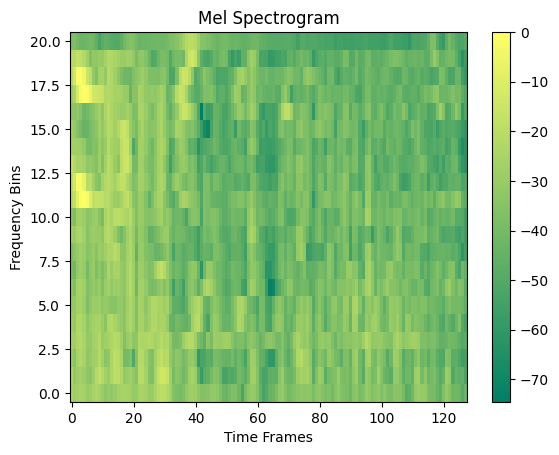

classical


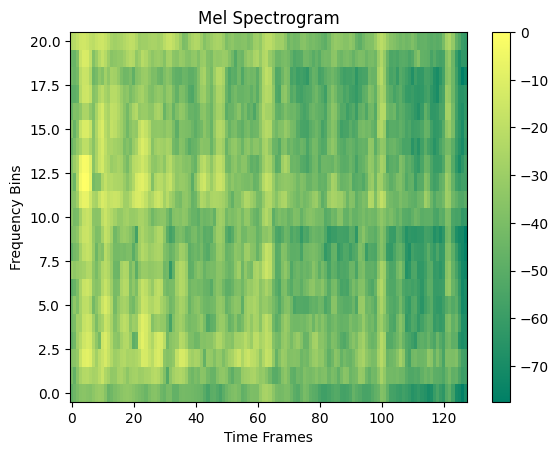

rock_metal_hardrock


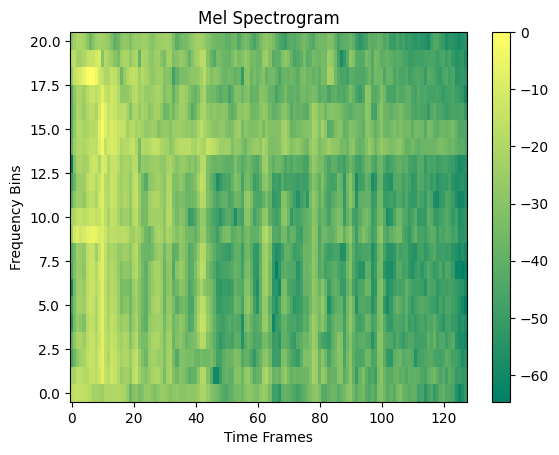

In [144]:
def plot_melgram(melgram):

  # Plot the melgram
  plt.imshow(melgram, cmap='summer', origin='lower', aspect='auto')
  plt.colorbar()
  plt.xlabel('Time Frames')
  plt.ylabel('Frequency Bins')
  plt.title('Mel Spectrogram')
  plt.show()

print(y_train[random_train_row])
plot_melgram(selected_train_row)
print(y_test[random_test_row])
plot_melgram(selected_test_row)
print(y_val[random_val_row])
plot_melgram(selected_val_row)

### Βήμα 2: Ορισμός Νευρωνικού Δικτύου
---
Ορίστε ένα Συνελικτικό Νευρωνικό Δίκτυο το οποίο να αποτελείται από
- Ακολουθία τεσσάρων συνελικτικών επιπέδων, με kernel size 5, ώστε να
επιτυγχάνεται η εξής ακολουθία καναλιών: 1, 16, 32, 64, 128
- Η έξοδος του τελευταίου συνελικτικού επιπέδου να εισέρχεται σε ένα πλήρως
συνδεδεμένο νευρωνικό δίκτυο 5 επιπέδων με αριθμό νευρώνων: x (διάσταση
εξόδου συνελικτικού δικτύου), 1024, 256, 32, out_dim


In [27]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU()
        )

        self.flat = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 5 * 112, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 128*560) # Flattening the tensor
        x = self.fc_layers(x)
        return x


Ας φτιάξουμε ένα στιγμυότυπο του μοντέλου στην GPU λόγω ταχύτητας.

In [28]:
# Setting the device to cuda
if torch.cuda.is_available():
  device="cuda"
else:
    device="cpu"

model_cnn = ConvNet().to(device)

# print the model structure
print(model_cnn)


ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=71680, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
)


### Βήμα 3: Εκπαίδευση δικτύου
---
Αλλάξτε όπου χρειάζεται, και τρέξτε, την διαδικασία εκπαίδευσης και αξιολόγησης ώστε να
μπορεί να εκπαιδευτεί και το νέο νευρωνικό δίκτυο.



In [13]:
'''
  Assisstant function that trains only one epoch (needed for evaluation)
'''
def new_train_loop(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)

    model.train()  # Set the model to training mode

    for batch, (X, y) in enumerate(dataloader):

        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # We need to unsqueexe in this functions for the batches to work
        X = torch.unsqueeze(X,1)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()





In [14]:
'''
  The test loop does not need the optimizer.
  We just pass the data through the trained model and measure the error in predictions.
  Returns a tuple with all the metrics asked for.
'''
def new_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    f1_metric = F1Score(task="multiclass", num_classes=4, average="macro").to(device)
    accuracy_metric = Accuracy(task="multiclass", num_classes=4).to(device)
    confusion_metric = ConfusionMatrix(task="multiclass", num_classes=4).to(device)

    with torch.no_grad():
        for X, y in dataloader:
            # if using gpu don't forget to move the data there
            X = X.to(device)
            y = y.to(device)

            # We need to unsqueexe in this functions for the batches to work
            X = torch.unsqueeze(X,1)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # Update the metric objects with predictions and labels
            f1_metric.update(pred, y)
            accuracy_metric.update(pred, y)
            confusion_metric.update(pred, y)

    # Calculate metrics
    f1 = f1_metric.compute()
    accuracy = accuracy_metric.compute()
    confusion = confusion_metric.compute().cpu().numpy()

    test_loss /= size

    return (test_loss, f1, accuracy, confusion)

Τι παρατηρείτε; Μπορεί να εκπαιδευτεί το δίκτυο;

In [29]:
# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate = 0.002

# define the optimizer object
optimizer = torch.optim.SGD(model_cnn.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

max_f1 = 0
best_model_cnn = None
max_epoch = 0

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Training the data
    new_train_loop(train_dataloader, model_cnn, loss_fn, optimizer)

    # Validating the data
    results = new_test_loop(validation_dataloader, model_cnn, loss_fn)

    # Evaluating if the current model has the best f1 score
    current_f1 = results[1]

    print(f"F1 macro average: {(100*results[1]):>0.1f}%")
    
    if current_f1 >= max_f1:
      max_epoch = t+1
      best_model_cnn = model_cnn
      max_f1 = current_f1

print("Done!")

Epoch 1
-------------------------------
F1 macro average: 26.8%
Epoch 2
-------------------------------
F1 macro average: 30.9%
Epoch 3
-------------------------------
F1 macro average: 36.0%
Epoch 4
-------------------------------
F1 macro average: 37.8%
Epoch 5
-------------------------------
F1 macro average: 49.7%
Epoch 6
-------------------------------
F1 macro average: 38.1%
Epoch 7
-------------------------------
F1 macro average: 43.8%
Epoch 8
-------------------------------
F1 macro average: 55.2%
Epoch 9
-------------------------------
F1 macro average: 59.9%
Epoch 10
-------------------------------
F1 macro average: 63.5%
Epoch 11
-------------------------------
F1 macro average: 58.1%
Epoch 12
-------------------------------
F1 macro average: 60.1%
Epoch 13
-------------------------------
F1 macro average: 65.1%
Epoch 14
-------------------------------
F1 macro average: 66.6%
Epoch 15
-------------------------------
F1 macro average: 63.0%
Epoch 16
-------------------------

Παρατηρούμε ότι ανά εποχή, βελτιώνονται οι επιδόσεις του μοντέλου μας αλλά όχι σταθερά. Η διαδικασία της εκπαίδευσης γίνεται πολύ αργά και από ότι φαίνεται πρέπει να το βελτιώσουμε. Ας το αξιολογήσουμε.

In [31]:
print(f"Best Epoch: ", max_epoch)
results = new_test_loop(test_dataloader, best_model_cnn, loss_fn)
print(f"Test Error: \n Avg loss: {results[0]:>8f},  F1 macro average: {(100*results[1]):>0.1f}%,  Accuracy: {(100*results[2]):>0.1f}%,  \n")
print("Confusion Matrix:")
print(results[3])
print("\n")

Best Epoch:  26
Test Error: 
 Avg loss: 0.138423,  F1 macro average: 64.6%,  Accuracy: 64.3%,  

Confusion Matrix:
[[152  27  46  99]
 [ 30 236   4  27]
 [ 35  10 246  65]
 [ 69  29  50 251]]




### Βήμα 4: Pooling and padding
---
Ενσωματώστε στα συνελικτικά επίπεδα max pooling με kerne size 2, και padding μεγέθους 2. Σχολιάστε την χρησιμότητα των δύο αυτών στοιχείων. Τι επίδοση πετυχαίνετε;

Θα φτιάξουμε ένα νέο νευρωνικό δίκτυο όπου θα εφαρμόζουμε pooling και padding σε κάθε επίπεδο του CNN.

In [32]:
'''
  Improved Convoluted Neural Network that implements padding and max pooling in its layers.
'''
class ImprovedConvNet(nn.Module):
    def __init__(self):
        super(ImprovedConvNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flat = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 128*8) # Flattening the tensor
        x = self.fc_layers(x)
        return x

Ας φτιάξουμε ένα στιγμυότυπο του μοντέλου στην GPU λόγω ταχύτητας.

In [33]:
# Setting the device to cuda
device="cuda"

model_icnn = ImprovedConvNet().to(device)

# print the model structure
print(model_icnn)

ImprovedConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_

Ας δούμε τις επιδόσεις του δικτύου.

In [34]:
# define the hyperparameters of the optimization/training process

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# define the learning rate
learning_rate = 0.002

# define the optimizer object
optimizer = torch.optim.SGD(model_icnn.parameters(), lr = learning_rate)

# define number of epochs
num_epochs = 30

max_f1 = 0
best_model_icnn = None
max_epoch = 0

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Training the data
    new_train_loop(train_dataloader, model_icnn, loss_fn, optimizer)

    # Validating the data
    results = new_test_loop(validation_dataloader, model_icnn, loss_fn)

    # Evaluating if the current model has the best f1 score
    current_f1 = results[1]

    print(f"F1 macro average: {(100*results[1]):>0.1f}%")
    
    if current_f1 >= max_f1:
      max_epoch = t+1
      best_model_icnn = model_icnn
      max_f1 = current_f1

print("Done!")

Epoch 1
-------------------------------
F1 macro average: 10.0%
Epoch 2
-------------------------------
F1 macro average: 11.3%
Epoch 3
-------------------------------
F1 macro average: 33.4%
Epoch 4
-------------------------------
F1 macro average: 28.8%
Epoch 5
-------------------------------
F1 macro average: 29.4%
Epoch 6
-------------------------------
F1 macro average: 50.5%
Epoch 7
-------------------------------
F1 macro average: 37.7%
Epoch 8
-------------------------------
F1 macro average: 45.1%
Epoch 9
-------------------------------
F1 macro average: 39.4%
Epoch 10
-------------------------------
F1 macro average: 47.6%
Epoch 11
-------------------------------
F1 macro average: 49.9%
Epoch 12
-------------------------------
F1 macro average: 47.0%
Epoch 13
-------------------------------
F1 macro average: 48.2%
Epoch 14
-------------------------------
F1 macro average: 57.0%
Epoch 15
-------------------------------
F1 macro average: 56.5%
Epoch 16
-------------------------

To ΜaxPooling χρησιμεύει στην μείωση των διαστάσεων των δεδομένων στα νευρωνικά δίκτυα το οποίο ενισχύει την ταχύτητα εκπαίδευσης των δεδομένων. Το ίδιο ισχύει και με το padding το οποίο κρατάει δεδομένα παραπέρα από τα σύνορα των δεδομένων που δόθηκαν στο μοντέλο. Παρατηρούμε ότι σε κάθε εποχή βελτιώνονται σταθρά οι επιδόσεις. Ας το αξιολογήσουμε.

In [35]:
print(f"Best Epoch: ", max_epoch)
results = new_test_loop(test_dataloader, best_model_icnn, loss_fn)
print(f"Test Error: \n Avg loss: {results[0]:>8f},  F1 macro average: {(100*results[1]):>0.1f}%,  Accuracy: {(100*results[2]):>0.1f}%,  \n")
print("Confusion Matrix:")
print(results[3])
print("\n")

Best Epoch:  30
Test Error: 
 Avg loss: 0.050137,  F1 macro average: 67.3%,  Accuracy: 67.2%,  

Confusion Matrix:
[[141  16  56 111]
 [ 38 240  11   8]
 [ 28   3 287  38]
 [ 53  11  78 257]]




Πήραμε 63.4% ακρίβεια με f1 στο 63.8%. Λίγο χειρότερα από ότι χωρίς pooling και padding αλλά σε πολύ λιγότερο χρόνο.

### Βήμα 5: Αλγόριθμοι βελτιστοποίησης
---
Υπάρχουν διαφορετικοί αλγόριθμοι βελτιστοποίησης ενός Νευρωνικού δικτύου. Δοκιμάστε
ένα σύνολο από optimizers που αναφέρονται εδώ, και φτιάξτε ένα πινακάκι που στις στήλες
θα περιέχει τους αλγόριθμους και στις γραμμές τις μετρικές accuracy και f1. Τι διαφορές
παρατηρείτε στην επίδοση;


In [36]:
'''
  Function that evaluates a given optimizer with a given model and dataloaders
'''
def evaluate_optimizer(optimizer, model_icnn, train_dataloader, test_dataloader, validation_dataloader):

  # define the hyperparameters of the optimization/training process

  # define the loss function
  loss_fn = nn.CrossEntropyLoss()

  # define number of epochs
  num_epochs = 30

  max_f1 = 0
  best_model_icnn = None
  max_epoch = 0

  # Training the model
  for t in range(num_epochs):

      # Training the data
      new_train_loop(train_dataloader, model_icnn, loss_fn, optimizer)

      # Validating the data
      results = new_test_loop(validation_dataloader, model_icnn, loss_fn)

      # Evaluating if the current model has the best f1 score
      current_f1 = results[1]
      
      if current_f1 >= max_f1:
        max_epoch = t+1
        best_model_icnn = model_icnn
        max_f1 = current_f1

  # Testing the model with the best epoch in terms of f1 score
  results = new_test_loop(test_dataloader, best_model_icnn, loss_fn)

  # Returning the f1 macro average score and the accuracy
  return (results[1], results[2])


Ας φτιάξουμε τα optimizers στην GPU λόγω ταχύτητας. Ορίζουμε χρήσιμες παραμέτρους.

In [63]:
if torch.cuda.is_available():
  device="cuda"
else:
    device="cpu"

# define the learning rate
learning_rate = 0.002

# we store all the model names and the results for the eventual presentation
all_models=[]
all_results=[]

Ξεκινάμε με το Adadelta αλγόριθμο.

In [64]:
model_Adadelta = ImprovedConvNet().to(device)
Adadelta_optimizer = torch.optim.Adadelta(model_Adadelta.parameters(), lr = learning_rate)
Adadelta_results = evaluate_optimizer(Adadelta_optimizer, model_Adadelta, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("Adadelta")
all_results.append(Adadelta_results)

Έπειτα με τον Adagrad.

In [65]:
model_Adagrad = ImprovedConvNet().to(device)
Adagrad_optimizer = torch.optim.Adagrad(model_Adagrad.parameters(), lr = learning_rate)
Adagrad_results = evaluate_optimizer(Adagrad_optimizer, model_Adagrad, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("Adagrad")
all_results.append(Adagrad_results)

Έπειτα με τον Adam.

In [66]:
model_Adam = ImprovedConvNet().to(device)
Adam_optimizer = torch.optim.Adam(model_Adam.parameters(), lr = learning_rate)
Adam_results = evaluate_optimizer(Adam_optimizer, model_Adam, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("Adam")
all_results.append(Adam_results)

Έπειτα με τον AdamW.

In [67]:
model_AdamW = ImprovedConvNet().to(device)
AdamW_optimizer = torch.optim.AdamW(model_AdamW.parameters(), lr = learning_rate)
AdamW_results = evaluate_optimizer(AdamW_optimizer, model_AdamW, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("AdamW")
all_results.append(AdamW_results)

Έπειτα με τον Adamax.

In [68]:
model_Adamax = ImprovedConvNet().to(device)
Adamax_optimizer = torch.optim.Adamax(model_Adamax.parameters(), lr = learning_rate)
Adamax_results = evaluate_optimizer(Adamax_optimizer, model_Adamax, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("Adamax")
all_results.append(Adamax_results)

Έπειτα με τον ASGD.

In [69]:
model_ASGD = ImprovedConvNet().to(device)
ASGD_optimizer = torch.optim.ASGD(model_ASGD.parameters(), lr = learning_rate)
ASGD_results = evaluate_optimizer(ASGD_optimizer, model_ASGD, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("ASGD")
all_results.append(ASGD_results)

Έπειτα με τον NAdam.

In [70]:
model_NAdam = ImprovedConvNet().to(device)
NAdam_optimizer = torch.optim.NAdam(model_NAdam.parameters(), lr = learning_rate)
NAdam_results = evaluate_optimizer(NAdam_optimizer, model_NAdam, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("NAdam")
all_results.append(NAdam_results)

Έπειτα με τον RAdam.

In [71]:
model_RAdam = ImprovedConvNet().to(device)
RAdam_optimizer = torch.optim.RAdam(model_RAdam.parameters(), lr = learning_rate)
RAdam_results = evaluate_optimizer(RAdam_optimizer, model_RAdam, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("RAdam")
all_results.append(RAdam_results)

Έπειτα με τον RMSpop.

In [72]:
model_RMSprop = ImprovedConvNet().to(device)
RMSprop_optimizer = torch.optim.RMSprop(model_RMSprop.parameters(), lr = learning_rate)
RMSprop_results = evaluate_optimizer(RMSprop_optimizer, model_RMSprop, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("RMSprop")
all_results.append(RMSprop_results)

Έπειτα με τον Rprop.

In [73]:
model_Rprop = ImprovedConvNet().to(device)
Rprop_optimizer = torch.optim.Rprop(model_Rprop.parameters(), lr = learning_rate)
Rprop_results = evaluate_optimizer(Rprop_optimizer, model_Rprop, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("Rprop")
all_results.append(Rprop_results)

Τέλος, με τον SGD.

In [74]:
model_SGD = ImprovedConvNet().to(device)
SGD_optimizer = torch.optim.SGD(model_SGD.parameters(), lr = learning_rate)
SGD_results = evaluate_optimizer(SGD_optimizer, model_SGD, train_dataloader, test_dataloader, validation_dataloader)
all_models.append("SGD")
all_results.append(SGD_results)

Ας φτιάξουμε τον πίνακα των αποτελεσμάτων ως dataframe.

In [75]:
# Splitting the f1_score with the accuracy results
accuracies=[]
f1_scores=[]

# We get F1 and accuracy as percentages with 2 decimals
for result in all_results:
  f1_scores.append("{:.2f}".format(100*result[0]) + "%")
  accuracies.append("{:.2f}".format(100*result[1]) + "%")
  
# Create a dictionary with all the data
data = {
    'Model': all_models,
    'F1-macro-average-score': f1_scores,
    'Accuracy': accuracies
    }

# Create the dataframe
df_results = pd.DataFrame(data)

# Show the results
df_results

,Model,F1-macro-average-score,Accuracy
0,Adadelta,48.82%,47.53%
1,Adagrad,75.51%,75.00%
2,Adam,68.94%,68.60%
3,AdamW,64.76%,63.88%
4,Adamax,74.22%,73.55%
5,ASGD,63.04%,63.01%
6,NAdam,65.00%,64.24%
7,RAdam,69.86%,69.62%
8,RMSprop,70.59%,69.99%
9,Rprop,65.06%,64.53%


Βλέπουμε ότι ο optimiser καθορίζει σε μεγάλο βαθμό τις επιδόσεις της εκπαίδευσης και της αξιολόγησης ενός μοντέλου. Παρατηρούμε ότι τις καλύτερες επιδόσεις τις παίρνουμε με το Adagrad optimizer και τις χειρότερες με το Adadelta. 